In [1]:
from dottamine import dotim
import numpy as np
import skimage as sk
# import napari
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import center_of_mass, rotate, gaussian_filter, zoom
import matplotlib.pyplot as plt
import copy

In [2]:
image = sk.io.imread('domes/70_denoised.tif')
# original_image = copy.copy(image[0])
image = np.transpose(image[4], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

In [3]:
dotter = dotim(image=image, is2D=False)
mask = dotter.get_mask(times=3, binshape=(2,2,2), v='+')

Convolving: 1/3
Convolving: 2/3
Convolving: 3/3
Deconvolving: 3/3
Deconvolving: 2/3
Deconvolving: 1/3


In [4]:
mask = mask.astype(np.uint8)

In [5]:
def smooth_array(arr, window_size):
    kernel = np.ones(window_size) / window_size
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    return smoothed_arr

## Close the mask
closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

## Find the top line of the mask
closed_mask = np.array(closed_mask)
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask



cell_mask = []
height_mask_total = []

for i in list(range(top_mask.shape[0])):

    print(i)

    slice_y = i

    ## Find the heights of the top mask array 
    height = [] # Is an array that contains the y values at which the mask starts
    for i in range(top_mask[slice_y].shape[1]):
        col = top_mask[slice_y][:, i]
        height.append(np.where(col == 1)[0][0]-20) # Add a value to move the line (+20)
    height = np.array(height)

    ## Smooth the top line
    window_size = 20
    height = smooth_array(height, window_size)

    ## Put the line inside a matrix. We have smoothed each line since top_mask is already this height matrix but non-smoothed.
    height_matrix = np.zeros((top_mask[slice_y].shape)) # Is the smoothed line on top of the mask

    for i in range(height_matrix.shape[1]-1):
        if abs(height[i]-height[i+1]) < 10: # Check the absolute difference value! # Should also take into account that two separate points toghether will also appear. (STD?)
            if height[i] == 0 and height[i-1] == 0:
                continue
            height_matrix[int(height[i])][i] = 1

    ## Blur the alone line and multiply it by the original image in order to get a masked image
    height_mask = cv2.GaussianBlur(height_matrix, (199, 199), 0)*image[slice_y]
    height_mask_total.append(height_mask)

    angles = [i for i in range(-60, 60+1, 5)]

    total_cell_mask = np.zeros(shape=(height_mask.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(height_mask, angle, reshape=False) # Be careful of the reshape=False
        # cell_top_mask_rot = rotate(height_matrix, angle)

        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            cell_border.append(np.argmax(col == max(col))) # Search for the first mask

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        total_cell_mask += cell_top_mask_rot

    cell_mask.append(total_cell_mask)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

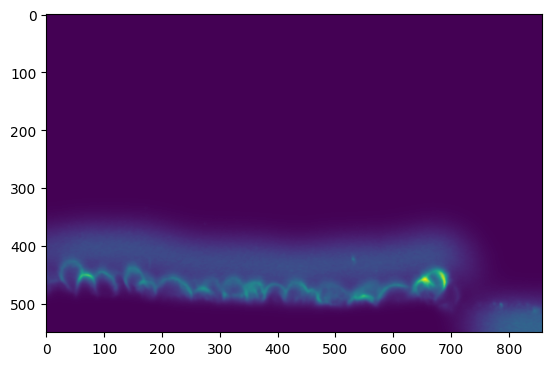

In [6]:
plt.imshow(height_mask_total[300])

In [7]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im
def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

In [8]:
import tifffile as tiff
cell_mask = np.array(cell_mask)
height_mask_total = np.array(height_mask_total)
top_mask = np.array(top_mask)
tiff.imwrite('./../ppujol/dome70allImages/cell_mask_05.tif', normalize_image(cell_mask, 255).astype(np.uint16), imagej=True)
tiff.imwrite('./../ppujol/dome70allImages/height_mask_05.tif', normalize_image(height_mask_total, 255).astype(np.uint16), imagej=True)
tiff.imwrite('./../ppujol/dome70allImages/top_mask_05.tif', normalize_image(top_mask, 255).astype(np.uint16), imagej=True)

OSError: [Errno 112] Host is down: '/mnt/Disk/dome70allImages/cell_mask_05.tif'